In [44]:
rm(list=ls())
library(refund);
library(ggplot2)
library(dplyr); 
library(dplyr); 
library(reshape2); 
library(fda);
set.seed(100)

# Table of contents: tbd

In [69]:
# set up "global" variables
n_obs = 20
n_var = 150 #number of vars
grid = seq(0, 1, length = n_var+1)
beta1 = sin(grid * 2 * pi)
beta2 = -dnorm(grid, mean=.2, sd=.03) +3*dnorm(grid, mean=.5,
sd=.04)+dnorm(grid, mean=.75, sd=.05)

nharm = 4 #number of fpc


In [70]:
data_generation <-function(){
var1 = 1
var2 = 5
var3 = 0.2

X <- matrix(0, nrow=n_obs, ncol=length(grid))
for(i2 in 1:n_obs){
    X[i2,]=X[i2,]+rnorm(length(grid), 0, var1)
    X[i2,]=X[i2,]+runif(1, 0, var2)
    X[i2,]=X[i2,]+rnorm(1, 0, var3)*grid
    
    for(j2 in 1:10){
        e =rnorm(2, 0, var1/j2^(2))
        X[i2,]=X[i2,]+e[1]*sin((2*pi)*grid*j2)
        X[i2,]=X[i2,]+e[2]*cos((2*pi)*grid*j2)
    }
    
}
return(X)
'
# This is a "more clear" setup

X <- matrix(0, nrow=n_obs, ncol=length(grid))
for(i2 in 1:n_obs){
    X[i2,]=X[i2,]+rnorm(length(grid), 0, var1)
    X[i2,]=X[i2,]+runif(1, 0, var2)
    X[i2,]=X[i2,]+rnorm(1, 0, var3)*grid
    
    e=abs(rnorm(2, 0, 1**(2)))
    X[i2,]=X[i2,]+e[1]*sin((2*pi)*grid)
    X[i2,]=X[i2,]+e[2]*cos((2*pi)*grid)
    
    
    
}
return(X)
'
}



[1] 151  20

[1] 0.848606852 0.081904601 0.050974913 0.008238505

[1] "done"

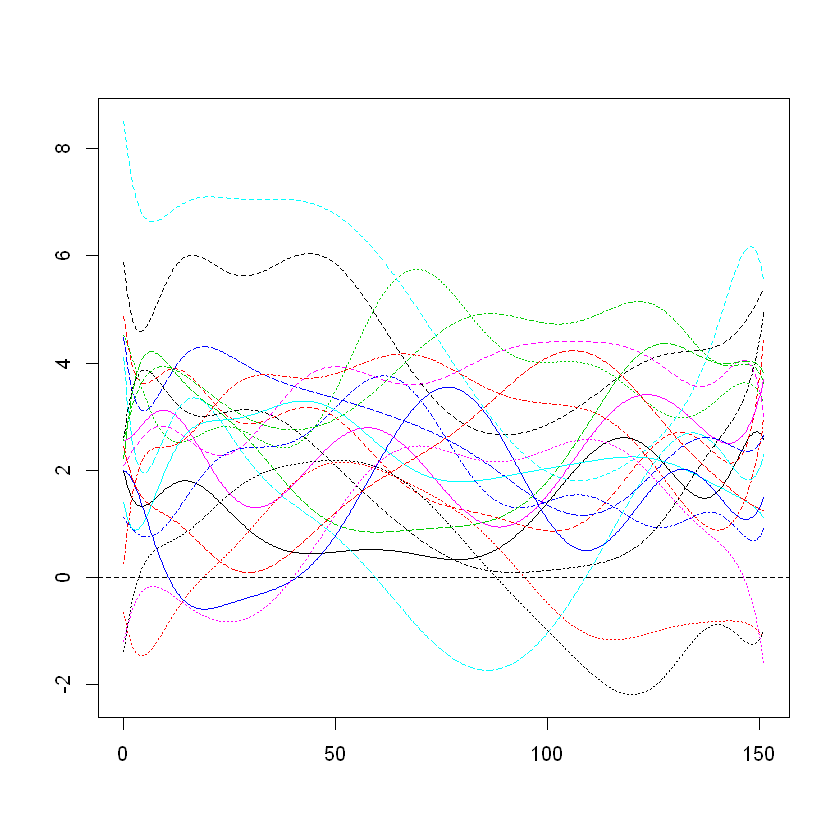

In [71]:
X = data_generation()
Y = X %*% beta1*(1/n_var)  + rnorm(n_obs, 0, 0.125) 
Y = as.numeric(Y)
final_X = t(X)
dim(final_X) # transpose, st obsverations now in columns // 
#todo: check if dim correct 


smallbasis  <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = 12, 7)
harmFdpar = fdPar(smallbasis)

smooth_basis <- smooth.basis(y = final_X, fdParobj=smallbasis)
smooth_basis_fd = smooth_basis$fd

simulated_pcaObj = pca.fd(smooth_basis$fd, nharm = nharm, harmfdPar = harmFdpar, centerfns = FALSE)

simulated_pcaObj$varprop 
# todo:use to choose appropriate level of explained variance

plot(smooth_basis_fd, ylab="", xlab="",col="gray")

[1] "\nxfdlist <- list(const=rep(1, n_obs), smooth_basis=smooth_basis_fd)\nbetabasis1 <- create.constant.basis(c(0, n_obs))\nbetafd1    <- fd(0, betabasis1)\nbetafdPar1 <- fdPar(betafd1)\nbetafd2    <- create.bspline.basis(rangeval = c(0, n_var+1), nbasis = 12, 7)\nbetafdPar2  <- fdPar(betafd2)\nbetalist <- list(const=betafdPar1, smooth_basis_fd=betafdPar2)\nf_regress <- fRegress(y = Y, xfdlist, betalist)\n"

[1] "done"

[1] 0.002515535


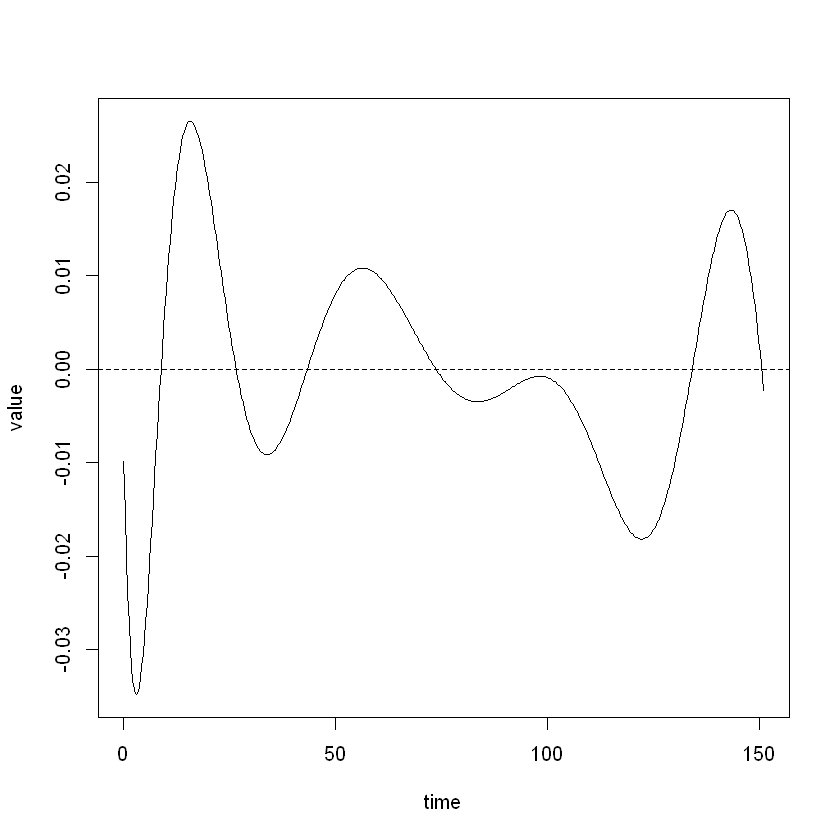

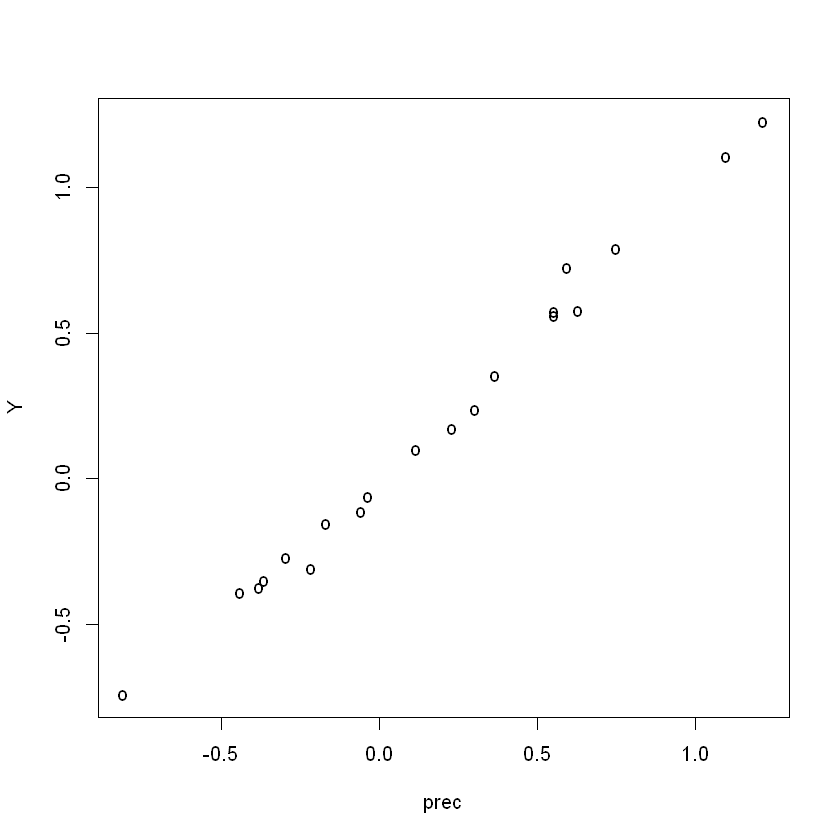

In [72]:
'
xfdlist <- list(const=rep(1, n_obs), smooth_basis=smooth_basis_fd)
betabasis1 <- create.constant.basis(c(0, n_obs))
betafd1    <- fd(0, betabasis1)
betafdPar1 <- fdPar(betafd1)
betafd2    <- create.bspline.basis(rangeval = c(0, n_var+1), nbasis = 12, 7)
betafdPar2  <- fdPar(betafd2)
betalist <- list(const=betafdPar1, smooth_basis_fd=betafdPar2)
f_regress <- fRegress(y = Y, xfdlist, betalist)
'
# also possible to use formula interface:
f_regress2 <- fRegress(Y ~ smooth_basis_fd)


prec <- f_regress2$yhatfdobj#, newdata = gasoline_fd_test, level = 0.95)

#  plot the data and the fit
plot(f_regress2$betaestlist[[2]])
MSE <- mean((Y-prec)^2)
print(MSE)
plot(prec, Y, type="p", pch="o")


## FPCR

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.117932165,0.052634615,2.2405819,4.061578e-02
simulated_pcaObj$scores1,0.001930163,0.001600278,1.2061426,2.464429e-01
simulated_pcaObj$scores2,0.043388894,0.002459029,17.6447275,1.922423e-11
simulated_pcaObj$scores3,-0.033822044,0.003148390,-10.7426471,1.931616e-08
simulated_pcaObj$scores4,-0.002914489,0.007784941,-0.3743752,7.133647e-01


[1] "\n          This all has to become flexible! S.t we can choose the desired components that explain a\n          certain amount of the variance and then this will become dynamic\n"

[1] "done"

[1] 0.00944096


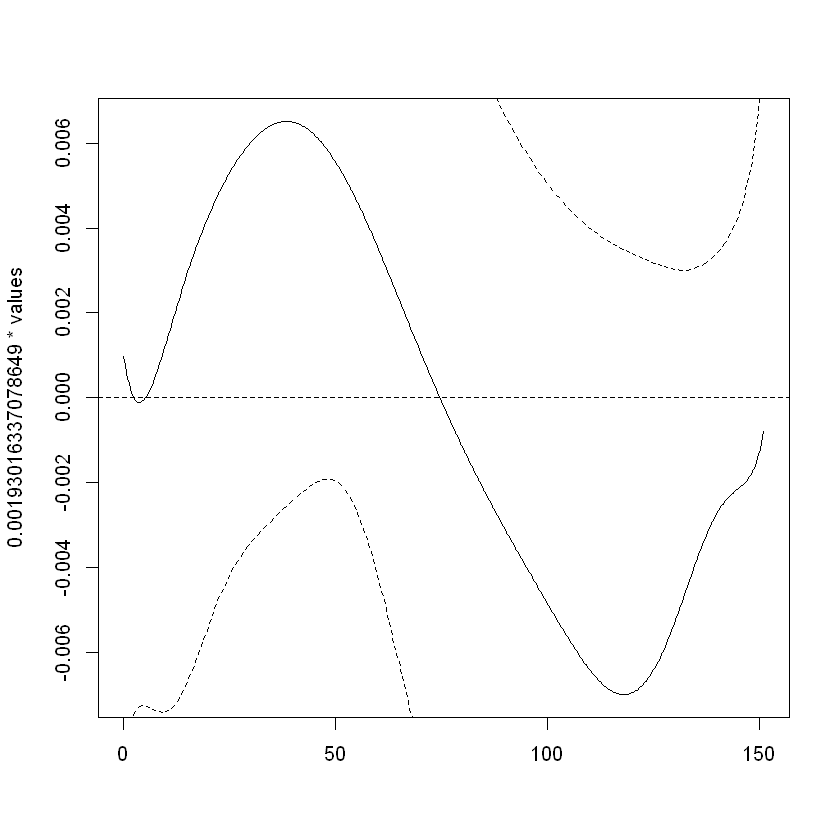

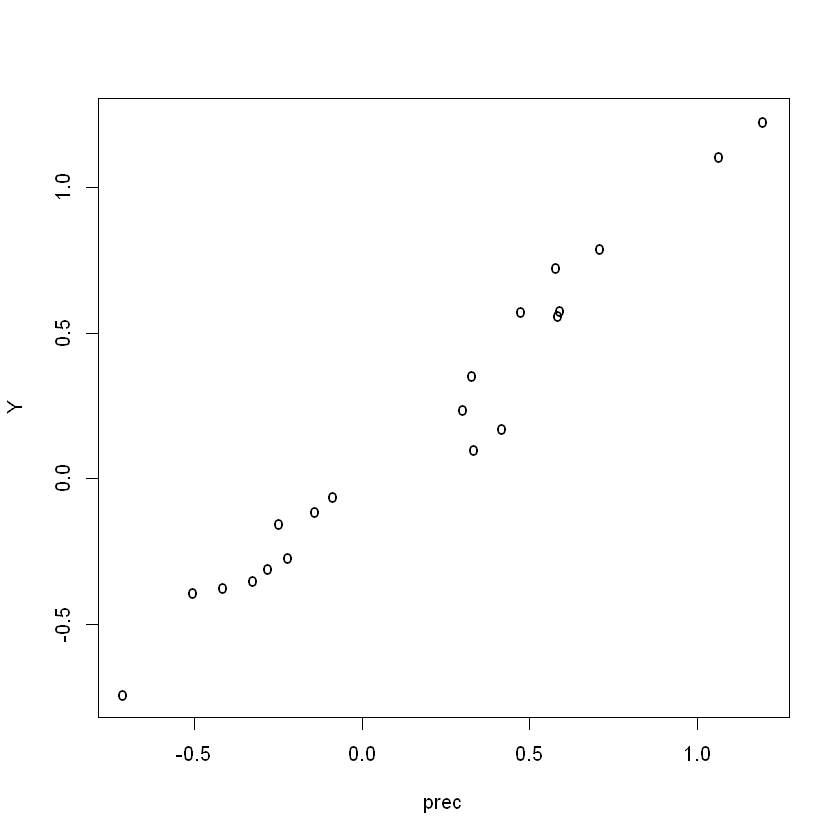

In [73]:
xfdlist <- list(const=rep(1, n_obs), smooth_basis=smooth_basis_fd)
betabasis1 <- create.constant.basis(c(0, n_obs))
betafd1    <- fd(0, betabasis1)
betafdPar1 <- fdPar(betafd1)
# here the magic happens!
betafdPar2  <- fdPar(simulated_pcaObj$harmonics)
betalist_pca <- list(const=betafdPar1, smooth_basis_fd=betafdPar2)

f_regress_pca <- lm(Y~simulated_pcaObj$scores)
pca_coeffs = summary(f_regress_pca)$coef
pca_coeffs

betafd = pca_coeffs[2,1]*simulated_pcaObj$harmonics[1] +
        pca_coeffs[3,1]*simulated_pcaObj$harmonics[2] + 
        pca_coeffs[4,1]*simulated_pcaObj$harmonics[3]+ 
        pca_coeffs[5,1]*simulated_pcaObj$harmonics[4]


coefvar = pca_coeffs[,2]**2

betavar = (pca_coeffs[2] * simulated_pcaObj$harmonics[1])**2 +
          (pca_coeffs[3] * simulated_pcaObj$harmonics[2])**2 +
          (pca_coeffs[4] * simulated_pcaObj$harmonics[3])**2 + 
          (pca_coeffs[5] * simulated_pcaObj$harmonics[4])**2
'
          This all has to become flexible! S.t we can choose the desired components that explain a
          certain amount of the variance and then this will become dynamic
'

plot(betafd)
lines(betafd+2*sqrt(betavar), lty=2, lwd=1)
lines(betafd-2*sqrt(betavar), lty=2, lwd=1)


prec <- predict(f_regress_pca)
#  plot the data and the fit
MSE <- mean((Y-prec)^2)
print(MSE)
plot(prec, Y, type="p", pch="o")
